# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment
from maddpg_agent import Agent
from collections import deque

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)


Number of agents: 2
Size of each action: 2


In [5]:
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def maddpg(n_episodes=500, max_t=1000, solved_score=0.5, consec_episodes=100, print_every=10, save_every=10, train_mode=True,
         continue_training = False):
    """Multi Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    scores_window = deque(maxlen=consec_episodes)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False  
    
    episodes_counter = 1
    # to continue Training, load the actor and critic checkpoints
    if continue_training:
        checkpoint_actor = torch.load('actor_temp.pt')
        checkpoint_critic = torch.load('critic_temp.pt') 
        #update i_episode for correct counting
        episodes_counter = checkpoint_actor['epoch']
        #load networks to continue training
        agent.actor_local.load_state_dict(checkpoint_actor['local_model_state_dict'])
        agent.actor_target.load_state_dict(checkpoint_actor['target_model_state_dict'])
        agent.actor_optimizer.load_state_dict(checkpoint_actor['optimizer_state_dict'])
        agent.actor_loss = checkpoint_actor['loss']
        mean_scores = checkpoint_actor['mean']
        moving_avgs = checkpoint_actor['moving_avgs']
        #load networks to continue training
        agent.critic_local.load_state_dict(checkpoint_critic['local_model_state_dict'])
        agent.critic_target.load_state_dict(checkpoint_critic['target_model_state_dict'])
        agent.critic_optimizer.load_state_dict(checkpoint_critic['optimizer_state_dict'])
        agent.critic_loss = checkpoint_critic['loss']
        
    
    for i_episode in range(episodes_counter, n_episodes+1):
        
        #print(episodes_counter)
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        #states = env_info.vector_observations                   # get current state for each agent 
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)                           # initialize score for each agent
        start_time = time.time()
        for t in range(max_t):
            actions = get_actions(states, add_noise=True)                  # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the next states ob agents
            rewards = env_info.rewards                          # get reward
            done = env_info.local_done                          # see if episode has finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step        
            if np.any(done):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % print_every == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-print_every, i_episode, np.max(scores_all[-print_every:]), moving_average[-1]))

        # determine if environment is solved and keep best performing models
        if moving_average[-1] >= solved_score:
            if not already_solved:
                print('<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-consec_episodes, moving_average[-1], consec_episodes))
                already_solved = True
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'models/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'models/checkpoint_critic_1.pth')
            elif ep_best_score >= best_score:
                print('<-- Best episode so far!\
                \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode, ep_best_score, moving_average[-1]))
                # save weights
                torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'models/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'models/checkpoint_critic_1.pth')
            elif (i_episode-best_episode) >= 200:
                # stop training if model stops converging
                print('<-- Training stopped. Best score not matched or exceeded for 200 episodes')
                break
            else:
                continue
        '''        
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
        if i_episode % save_every == 0:    
            #saving network parameters in case of notebook crash
            print('Start')
            torch.save({
            'epoch': i_episode,
            'local_model_state_dict': agent.actor_local.state_dict(),
            'target_model_state_dict': agent.actor_target.state_dict(),    
            'optimizer_state_dict': agent.actor_optimizer.state_dict(),
            'loss': agent.actor_loss,
            'mean': mean_scores,
            'moving_avgs': moving_avgs
            }, 'actor_temp.pt')
            
            torch.save({
            'epoch': i_episode,
            'local_model_state_dict': agent.critic_local.state_dict(),
            'target_model_state_dict': agent.critic_target.state_dict(),    
            'optimizer_state_dict': agent.critic_optimizer.state_dict(),
            'loss': agent.critic_loss,
            }, 'critic_temp.pt')
            print('Network parameters saved')
        if train_mode and mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
          '''  
    return scores_all, moving_average

In [7]:
def get_actions(states, add_noise=True):
    '''gets actions for both agents and combines them into one array'''
    action_0 = agent_0.act(states, add_noise)    # agent 0 chooses an action
    action_1 = agent_1.act(states, add_noise)    # agent 1 chooses an action
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [8]:
# initialize agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

In [9]:
'''
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1         # learning timestep interval
LEARN_NUM = 5           # number of learning passes
GAMMA = 0.99            # discount factor
TAU = 8e-3              # for soft update of target parameters
OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
EPS_START = 5.0         # initial value for epsilon in noise decay process in Agent.act()
EPS_EP_END = 300        # episode to end the noise decay process
EPS_FINAL = 0           # final value for epsilon after decay
'''
# run the training loop
scores, avgs = maddpg()

C:\Users\Annika\deeplearning\maddpg_agent.py:121: UserWarning: Using a target size (torch.Size([128, 2])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(Q_expected, Q_targets)


Episodes 0000-0010	Max Reward: 0.000	Moving Average: 0.000
Episodes 0010-0020	Max Reward: 0.000	Moving Average: 0.000
Episodes 0020-0030	Max Reward: 0.100	Moving Average: 0.003
Episodes 0030-0040	Max Reward: 0.200	Moving Average: 0.008
Episodes 0040-0050	Max Reward: 0.100	Moving Average: 0.014
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.017
Episodes 0060-0070	Max Reward: 0.200	Moving Average: 0.019
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.021
Episodes 0080-0090	Max Reward: 0.100	Moving Average: 0.022
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.025
Episodes 0100-0110	Max Reward: 0.100	Moving Average: 0.029
Episodes 0110-0120	Max Reward: 0.100	Moving Average: 0.037
Episodes 0120-0130	Max Reward: 0.200	Moving Average: 0.043
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.048
Episodes 0140-0150	Max Reward: 0.100	Moving Average: 0.045
Episodes 0150-0160	Max Reward: 0.100	Moving Average: 0.046
Episodes 0160-0170	Max Reward: 0.100	Moving Average: 0.0

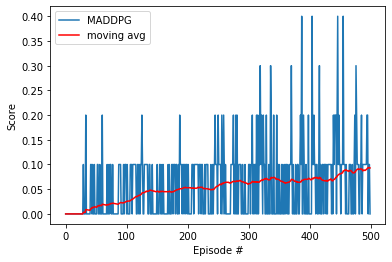

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()